** Initialization of spark **

In [1]:
import findspark
findspark.init()

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc

spark = SparkSession.builder \
            .master('local') \
            .appName('hotels') \
            .getOrCreate()
            
sc = spark.sparkContext 

In [2]:
def mapByHotelName(row):
    key = row['Hotel Name']
    val = 1
    return (key,val)

def reduceByCount(val1, val2):
    return (val1 + val2)

hotels_num = 150

hotels_rdd = spark.read.csv('../input/Hotels_Data_Changed.csv',header=True).rdd
hotel_names_top150 = hotels_rdd \
            .map(mapByHotelName) \
            .reduceByKey(reduceByCount) \
            .sortBy(lambda x: x[1], ascending = False) \
            .map(lambda x: x[0]) \
            .take(hotels_num)
            
hotels_top = hotels_rdd.filter(lambda x: x['Hotel Name'] in hotel_names_top150)

In [3]:
def mapByCheckinDate(row):
    key = row['Checkin Date']
    val = 1
    return (key,val)

checkin_date_num = 40

checkin_top_keys = hotels_top \
            .map(mapByCheckinDate) \
            .reduceByKey(reduceByCount) \
            .sortBy(lambda x: x[1], ascending = False) \
            .map(lambda x: x[0]) \
            .take(checkin_date_num)
            
checkin_top_keys.sort()
            
top_hotels_in_date = hotels_top.filter(lambda x: x['Checkin Date'] in checkin_top_keys) \
                        .sortBy(lambda x: x['Discount Code']) \
                        .sortBy(lambda x: x['Hotel Name']) \
                        .sortBy(lambda x: x['Checkin Date'])

In [7]:
def mapHotelDatesDiscountCode(row):
    key = (row['Hotel Name'],row['Checkin Date'],row['Discount Code'])
    val = float(row['Discount Price'])
    return (key,val)

def reduceByHotelAndCheckinDate(val1,val2):
    if val1 == -1:
        return val2
    elif val2 == -1:
        return val1
    else:
        return min(val1,val2)

def createAllKeys(hotels,dates,codes):
    names_keys = sc.parallelize(hotels)
    dates_keys = sc.parallelize(dates)
    codes_keys = sc.parallelize(codes)
    return names_keys.cartesian(dates_keys.cartesian(codes_keys)).map(lambda x: (x[0], x[1][0], x[1][1]))

hotels_date_price_missing_data = createAllKeys(hotel_names_top150,checkin_top_keys,['1','2','3','4']).map(lambda x: (x, -1))

hotels_date_price = \
        top_hotels_in_date \
                .map(mapHotelDatesDiscountCode)
            
hotels_date_price_all_values = sc.union([hotels_date_price_missing_data, hotels_date_price]).reduceByKey(reduceByHotelAndCheckinDate).sortByKey()
hotels_date_price_all_values = hotels_date_price_all_values.map(lambda x: (x[0][0], x[1])).groupByKey().sortByKey().mapValues(list)

In [9]:
def normalise(prices):
    filtered_prices = list(filter(lambda x: x != -1, prices))
    
    if len(filtered_prices) == 0:
        return prices
    
    max_price = max(filtered_prices)
    min_price = min(filtered_prices)
    
    diff = max_price - min_price
    
    arr = []
    for price in prices:
        if price == -1:
            arr.append(price)
        elif diff == 0:
            arr.append(0)
        else:
            arr.append(float(price - min_price) * 100/diff)
            
    return arr

normalised_hotels_prices = hotels_date_price_all_values.map(lambda x: (x[0], normalise(x[1])))
normalised_prices = normalised_hotels_prices.values()

In [6]:
from pyspark.mllib.clustering import BisectingKMeans, BisectingKMeansModel

k=hotels_num
difference = 0
cost = 0
last_cost = 0
for x in range(1,k):
    model = BisectingKMeans().train(normalised_prices, k=x)
    cost = model.computeCost(normalised_prices)
    if (x == 1):
        last_cost = cost
    difference = last_cost - cost
    last_cost = cost
    print("With K={}".format(x))
    print("Within Set Sum of Squared Errors = " + str(cost))
    print("The difference from k={0} : {1}".format(x-1,difference))
    print('--'*30)

With K=1
Within Set Sum of Squared Errors = 15818627.580700587
The difference from k=0 : 0.0
------------------------------------------------------------
With K=2
Within Set Sum of Squared Errors = 13243306.321940174
The difference from k=1 : 2575321.258760413
------------------------------------------------------------
With K=3
Within Set Sum of Squared Errors = 12922856.934088053
The difference from k=2 : 320449.38785212114
------------------------------------------------------------
With K=4
Within Set Sum of Squared Errors = 12445950.970017843
The difference from k=3 : 476905.96407021023
------------------------------------------------------------
With K=5
Within Set Sum of Squared Errors = 12329739.743887588
The difference from k=4 : 116211.22613025457
------------------------------------------------------------
With K=6
Within Set Sum of Squared Errors = 12140463.907137807
The difference from k=5 : 189275.83674978092
------------------------------------------------------------
Wi

With K=50
Within Set Sum of Squared Errors = 7896587.075640243
The difference from k=49 : 109579.72779061459
------------------------------------------------------------
With K=51
Within Set Sum of Squared Errors = 7739293.308761178
The difference from k=50 : 157293.76687906496
------------------------------------------------------------
With K=52
Within Set Sum of Squared Errors = 7713170.654286005
The difference from k=51 : 26122.65447517298
------------------------------------------------------------
With K=53
Within Set Sum of Squared Errors = 7573915.908554096
The difference from k=52 : 139254.74573190883
------------------------------------------------------------
With K=54
Within Set Sum of Squared Errors = 7434607.22412079
The difference from k=53 : 139308.68443330564
------------------------------------------------------------
With K=55
Within Set Sum of Squared Errors = 7339216.686454643
The difference from k=54 : 95390.53766614757
--------------------------------------------

With K=99
Within Set Sum of Squared Errors = 3647506.173193007
The difference from k=98 : 178137.56865721475
------------------------------------------------------------
With K=100
Within Set Sum of Squared Errors = 3578565.949906308
The difference from k=99 : 68940.22328669857
------------------------------------------------------------
With K=101
Within Set Sum of Squared Errors = 3540384.5451427046
The difference from k=100 : 38181.40476360358
------------------------------------------------------------
With K=102
Within Set Sum of Squared Errors = 3370446.557105989
The difference from k=101 : 169937.98803671543
------------------------------------------------------------
With K=103
Within Set Sum of Squared Errors = 3298156.7499142406
The difference from k=102 : 72289.80719174864
------------------------------------------------------------
With K=104
Within Set Sum of Squared Errors = 3153492.5717841503
The difference from k=103 : 144664.17813009024
--------------------------------

With K=147
Within Set Sum of Squared Errors = 137829.9225011955
The difference from k=146 : 68450.5351936032
------------------------------------------------------------
With K=148
Within Set Sum of Squared Errors = 106738.22783957426
The difference from k=147 : 31091.69466162125
------------------------------------------------------------
With K=149
Within Set Sum of Squared Errors = 51500.27432210432
The difference from k=148 : 55237.95351746994
------------------------------------------------------------


In [10]:
from pyspark.mllib.clustering import BisectingKMeans, BisectingKMeansModel

k=30
model = BisectingKMeans().train(normalised_prices, k, maxIterations=20)
cost = model.computeCost(normalised_prices)
print("Within Set Sum of Squared Errors = " + str(cost))

Within Set Sum of Squared Errors = 9369511.300963003


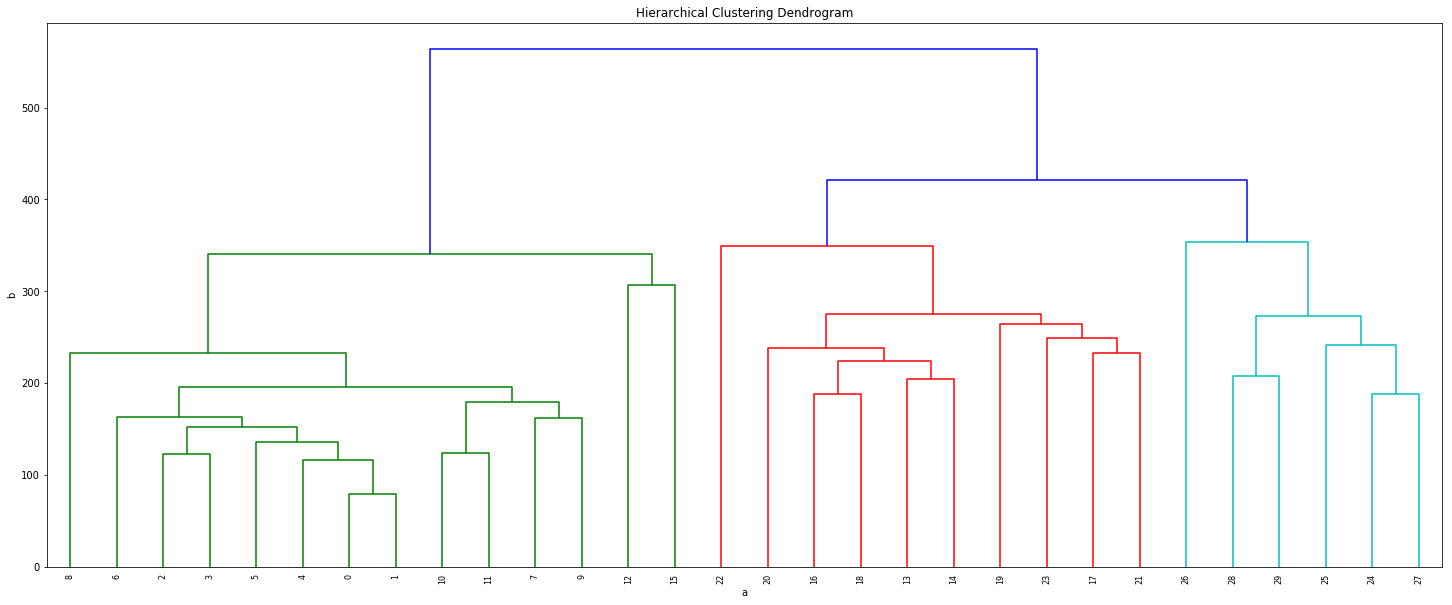

In [12]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from matplotlib import pyplot as plt

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('a')
plt.ylabel('b')

dendrogram(
linkage(model.clusterCenters, method='complete'),
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    truncate_mode='lastp',  # show only the last p merged clusters
    p=k,  # show only the last p merged clusters
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [192]:
import csv, io

def list_to_csv_str(x):
    """Given a list of strings, returns a properly-csv-formatted string."""
    output = io.StringIO("")
    csv.writer(output).writerow(x)
    return output.getvalue().strip() # remove extra newline

# ... do stuff with your rdd ...
rdd = normalised_prices.map(list_to_csv_str)
rdd.saveAsTextFile("output_directory")

TypeError: computeCost() missing 1 required positional argument: 'x'